# Dropout

Здравствуйте. В данном ноутбуке мы с вами познакомимся с идеей dropout и попробуем применить ее на практике. Давайте установим все необходимы библиотеки и импортируем их.

In [1]:
!pip install numpy tensorflow tensorflow_datasets seaborn matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

Зафиксируем случайный seed для воспроизводимости результатов этого ноутбука.

In [3]:
SEED = 1231232
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Для простоты обучения и работы возьмем уже знакомый нам набор данных Ирисов Фишера. Подготовим его к обучению.

In [4]:
ds_train, ds_test = tfds.load(
    name='iris',
    split=['train[:70%]', 'train[70%:]'],
    as_supervised=True
)

input_shape = (4, )  
batch_size = 10      
amount_of_classes = 3

def make_one_hot(x, y):
    return x, tf.one_hot(y, depth=amount_of_classes)

ds_train = (
    ds_train
    .map(make_one_hot)
    .shuffle(len(ds_train))
    .batch(batch_size, drop_remainder=True)
)
    
ds_test = (
    ds_test
    .map(make_one_hot)
    .batch(batch_size, drop_remainder=True)
)

Metal device set to: Apple M1 Pro


2022-07-24 18:32:23.357385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 18:32:23.357760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model = keras.Sequential()
model.add(InputLayer(input_shape=input_shape, batch_size=batch_size))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

EPOCHS = 20
history = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_test, verbose=0)

2022-07-24 18:32:37.202241: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 18:32:37.206311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-24 18:32:37.644517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Установим параметры библиотеки matplotlib для более красивой визуализации.

In [6]:
plt.rcParams['figure.figsize'] = [15, 8]
sns.set_style("darkgrid")

И создадим функцию, которая будет визуализировать историю обучения сети. 

In [7]:
def show_history(history, epochs):
    fig, axes = plt.subplots(2, 1)

    axes[0].plot(range(epochs), history.history['loss'])
    axes[0].plot(range(epochs), history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    axes[0].set_title('Losses')

    axes[1].plot(range(epochs), history.history['categorical_accuracy'])
    axes[1].plot(range(epochs), history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])
    axes[1].set_title('Accuracy')

    plt.show()

Итак, давайте визуализируем историю обучения и посмотрим на соответствие метрик на тренировочной и тестовой выборках.

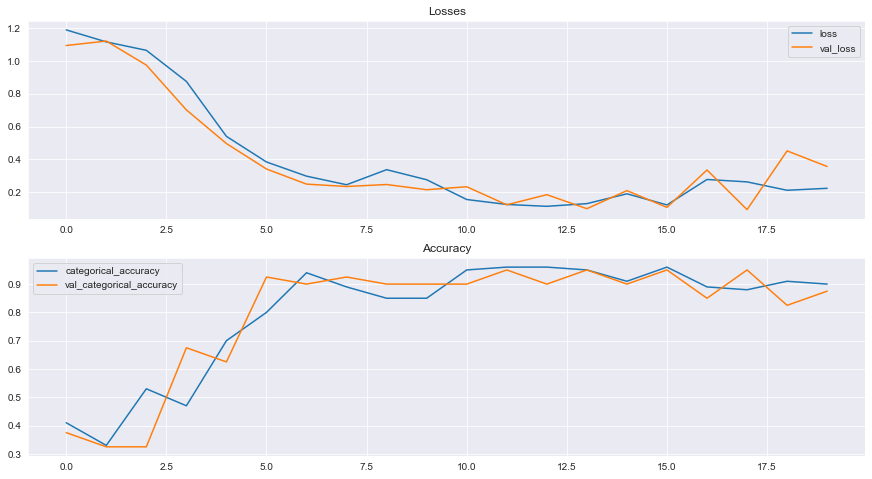

In [8]:
show_history(history, EPOCHS)

Далее давайте создадим аналогичную сеть с механизмом Dropout, поставленным между слоями нейронной сети. В качестве параметра указывается доля нейронов, которые будут отключаться на каждом шаге обучения. 

In [9]:
model = keras.Sequential()
model.add(InputLayer(input_shape=input_shape, batch_size=batch_size))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

history = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_test, verbose=0)

2022-07-24 18:32:55.988952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-24 18:32:56.224115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Аналогичным образом визуализируем результат обучения модели с включенным механизмом Dropout.

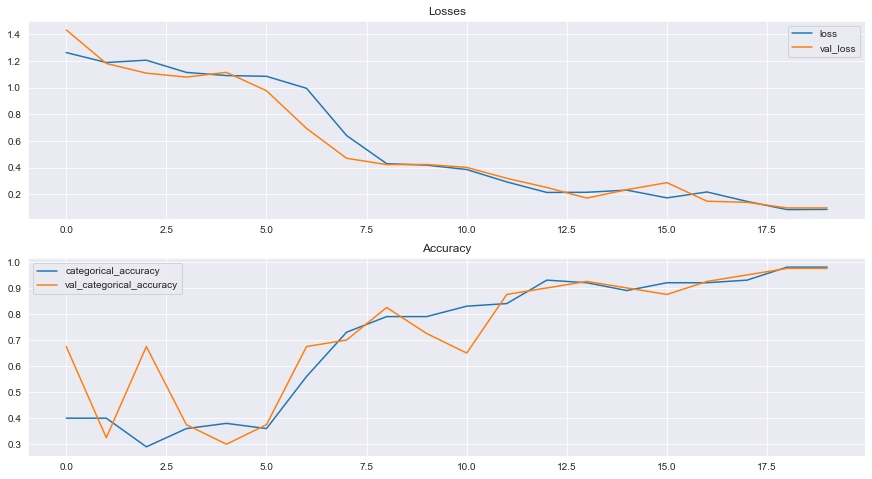

In [10]:
show_history(history, EPOCHS)

Стал ли разрыв между валидационными и тренировочными метриками менее значительным? В случае достаточно простого набора данных этот эффект не всегда удается заметить, однако наличие dropout'а в сети почти всегда положительно сказывается на процессе обучения.  

Мы рекомендуем вам изучить несколько популярных архитектур нейронных сетей и отметить наличие или отсутствие в них данного механизма.
